In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

In [2]:
dat=pd.read_csv("spectrum_ch4.txt",delimiter=",",names=("wav","flux"))

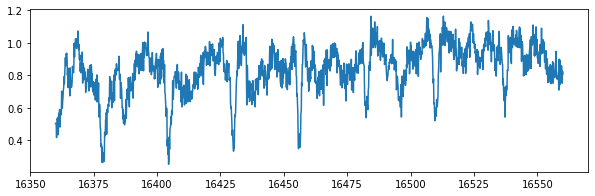

In [3]:
wavd=dat["wav"].values
flux=dat["flux"].values
nusd=jnp.array(1.e8/wavd[::-1])
sigmain=0.05
norm=20000
nflux=flux/norm+np.random.normal(0,sigmain,len(wavd))
plt.figure(figsize=(10,3))
plt.plot(wavd[::-1],nflux)


In [4]:
from exojax.spec import rtransfer as rt
from exojax.spec import dit, modit
from jax import jit
from exojax.spec.exomol import gamma_exomol
from exojax.spec import gamma_natural
from exojax.spec.hitran import SijT


In [5]:
from exojax.spec import rtransfer as rt
from exojax.spec.rtransfer import nugrid
from exojax.spec.rtransfer import rtrun, dtauM, dtauCIA, nugrid
from exojax.spec import planck, response
from exojax.spec.lpf import xsvector
from exojax.spec import molinfo
from exojax.utils.constants import RJ, pc, Rs, c

NP=100
Parr, dParr, k=rt.pressure_layer(NP=NP)
Nx=5000
nus,wav,res=nugrid(np.min(wavd)-5.0,np.max(wavd)+5.0,Nx,unit="AA",xsmode="modit")

R=100000.
beta=c/(2.0*np.sqrt(2.0*np.log(2.0))*R)

molmassCH4=molinfo.molmass("CH4")
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molinfo.molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR

Mp = 33.2 

nugrid is log: mode= modit


In [6]:
from exojax.spec import moldb, contdb
mdbCH4=moldb.MdbExomol('.database/CH4/12C-1H4/YT10to10/',nus,crit=1.e-30)
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)

Background atmosphere:  H2
Reading transition file
.broad is used.
Broadening code level= a1
default broadening parameters are used for  12  J lower states in  29  states
H2-H2


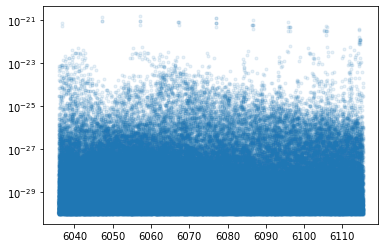

In [7]:
plt.plot(mdbCH4.nu_lines,mdbCH4.Sij0,".",alpha=0.1)
plt.yscale("log")

In [8]:
#reference pressure for a T-P model                                             
Pref=1.0 #bar
ONEARR=np.ones_like(Parr)
ONEWAV=jnp.ones_like(nflux)

In [9]:
from jax import random
import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

from exojax.spec import normalized_doppler_sigma
import numpy as np

In [10]:
Nfold=1
dLarray=dit.make_dLarray(Nfold,1)
mednus=np.median(nus)
dv=nus/R
dv_lines=mdbCH4.nu_lines/R

In [18]:
#precomputing gdm_ngammaL
from exojax.spec.modit import minmax_dgmatrix,precompute_dgmatrix 
from jax import jit, vmap
T0inarray=[1100.0,1500.0]
alphainarray=[0.05,0.2]

res=0.2
set_dgm_minmax=[]
for T0in in T0inarray:
    for alphain in alphainarray:
        Tarr = T0in*(Parr/Pref)**alphain
        qt_CH4=vmap(mdbCH4.qr_interp)(Tarr)
        SijM_CH4=jit(vmap(SijT,(0,None,None,None,0)))\
            (Tarr,mdbCH4.logsij0,mdbCH4.dev_nu_lines,mdbCH4.elower,qt_CH4)
        gammaLMP_CH4 = jit(vmap(gamma_exomol,(0,0,None,None)))\
            (Parr,Tarr,mdbCH4.n_Texp,mdbCH4.alpha_ref)
        gammaLMN_CH4=gamma_natural(mdbCH4.A)
        gammaLM_CH4=gammaLMP_CH4+gammaLMN_CH4[None,:]
        ngammaLM_CH4=gammaLM_CH4/dv_lines
        
        #append dgm_minmax
        set_dgm_minmax.append(minmax_dgmatrix(ngammaLM_CH4,res))
        
set_dgm_minmax=np.array(set_dgm_minmax)

dgm_ngammaL=precompute_dgmatrix(set_dgm_minmax,res=res)

5


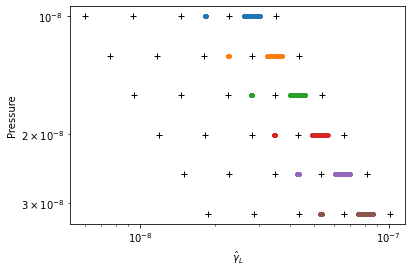

In [20]:
#dgm for gamma_L
from exojax.plot.ditplot import plot_dgmn
plot_dgmn(Parr,dgm_ngammaL,ngammaLM_CH4,0,6)


In [110]:
if True:
    if True:
        Rp=0.88
        Mp=33.2
        g=2478.57730044555*Mp/Rp**2
        #g=1.e5 #gravity cm/s2
        MMR=0.0059 #mass mixing ratio
        
        RV=10.0 #RV km/s
        vsini=20.0 #Vsini km/s
        u1=0.0 #limb darkening u1
        u2=0.0 #limb darkening u2
        
        Rinst=100000.
        beta=c/(2.0*np.sqrt(2.0*np.log(2.0))*Rinst) #IP sigma need check 
        
        #core part
        SijM_CH4=jit(vmap(SijT,(0,None,None,None,0)))\
            (Tarr,mdbCH4.logsij0,mdbCH4.dev_nu_lines,mdbCH4.elower,qt_CH4)
        gammaLMP_CH4 = jit(vmap(gamma_exomol,(0,0,None,None)))\
            (Parr,Tarr,mdbCH4.n_Texp,mdbCH4.alpha_ref)
        gammaLMN_CH4=gamma_natural(mdbCH4.A)
        gammaLM_CH4=gammaLMP_CH4+gammaLMN_CH4[None,:]
        ngammaLM_CH4=gammaLM_CH4/dv_lines
                
        nsigmaDl=normalized_doppler_sigma(Tarr,molmassCH4,R)[:,jnp.newaxis]

        xsm_CH4=modit.xsmatrix(mdbCH4.nu_lines-mednus,nsigmaDl,ngammaLM_CH4,SijM_CH4,\
                               nus-mednus,dgm_ngammaL,dLarray,dv_lines,dv)
        
        ##### CRITICAL POINT for jnp #####
        #xsmnp=np.array(xsm_CH4)
        #print(len(xsmnp[xsmnp<0.0]))
        #xsmnp[xsmnp<0.0]=0.0
        #xsmditc=jnp.array(xsmnp)
        #xsmnp=np.array(xsm_CH4)
        #print(len(xsmnp[xsmnp<0.0]))
        #xsmnp[xsmnp<0.0]=0.0
        #xsmditc=jnp.array(xsmnp)
        ###################################
        
        dtaumCH4=dtauM(dParr,jnp.abs(xsm_CH4),MMR_CH4*ONEARR,molmassCH4,g)
        #CIA                                                                    
        dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
                          mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)
        dtau=dtaumCH4+dtaucH2H2
        sourcef = planck.piBarr(Tarr,nus)
        F0=rtrun(dtau,sourcef)/norm
        Frot=response.rigidrot(nus,F0,vsini,u1,u2)
        mu=response.ipgauss_sampling(nusd,nus,Frot,beta,RV)

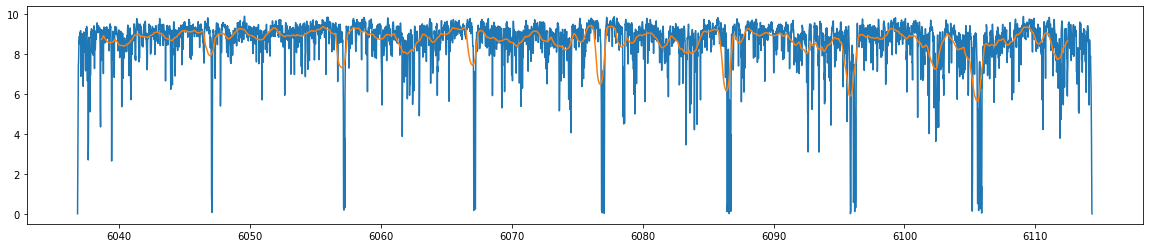

In [111]:
fig=plt.figure(figsize=(20,4))
plt.plot(nus,F0)
plt.plot(nusd,mu)

In [112]:
def model_c(nu1,y1):
    Rp = numpyro.sample('Rp', dist.Uniform(0.4,1.2))
    RV = numpyro.sample('RV', dist.Uniform(5.0,15.0))
    MMR_CH4 = numpyro.sample('MMR_CH4', dist.Uniform(0.0,0.015))
    T0 = numpyro.sample('T0', dist.Uniform(1000.0,1500.0))
    alpha=numpyro.sample('alpha', dist.Uniform(0.05,0.2))
    vsini = numpyro.sample('vsini', dist.Uniform(15.0,25.0))
    g=2478.57730044555*Mp/Rp**2 #gravity                                        
    u1=0.0
    u2=0.0
    #T-P model//                                                                
    Tarr = T0*(Parr/Pref)**alpha

    #line computation CH4                                                      
    qt_CH4=vmap(mdbCH4.qr_interp)(Tarr)

    def obyo(y,tag,nusd,nus,mdb_CH4,cdbH2H2):
        #CH4                                                                    
        SijM_CH4=jit(vmap(SijT,(0,None,None,None,0)))\
            (Tarr,mdbCH4.logsij0,mdbCH4.dev_nu_lines,mdbCH4.elower,qt_CH4)
        gammaLMP_CH4 = jit(vmap(gamma_exomol,(0,0,None,None)))\
            (Parr,Tarr,mdbCH4.n_Texp,mdbCH4.alpha_ref)
        gammaLMN_CH4=gamma_natural(mdbCH4.A)
        gammaLM_CH4=gammaLMP_CH4+gammaLMN_CH4[None,:]
        ngammaLM_CH4=gammaLM_CH4/dv_lines
                
        nsigmaDl=normalized_doppler_sigma(Tarr,molmassCH4,R)[:,jnp.newaxis]

        xsm_CH4=modit.xsmatrix(mdbCH4.nu_lines-mednus,nsigmaDl,ngammaLM_CH4,SijM_CH4,\
                               nus-mednus,dgm_ngammaL,dLarray,dv_lines,dv)
        dtaumCH4=dtauM(dParr,jnp.abs(xsm_CH4),MMR_CH4*ONEARR,molmassCH4,g)
        #CIA                                                                    
        dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
                          mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)
        dtau=dtaumCH4+dtaucH2H2
        sourcef = planck.piBarr(Tarr,nus)
        F0=rtrun(dtau,sourcef)/norm
        
        Frot=response.rigidrot(nus,F0,vsini,u1,u2)
        mu=response.ipgauss_sampling(nusd,nus,Frot,beta,RV)
        numpyro.sample(tag, dist.Normal(mu, sigmain), obs=y)
    
    obyo(y1,"y1",nu1,nus,mdbCH4,cdbH2H2)



In [115]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 300, 600
kernel = NUTS(model_c,forward_mode_differentiation=True)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key_, nu1=nusd, y1=nflux)

sample: 100%|█| 900/900 [29:33<00:00,  1.97s/it, 10 steps of size 1.08e-01. acc.


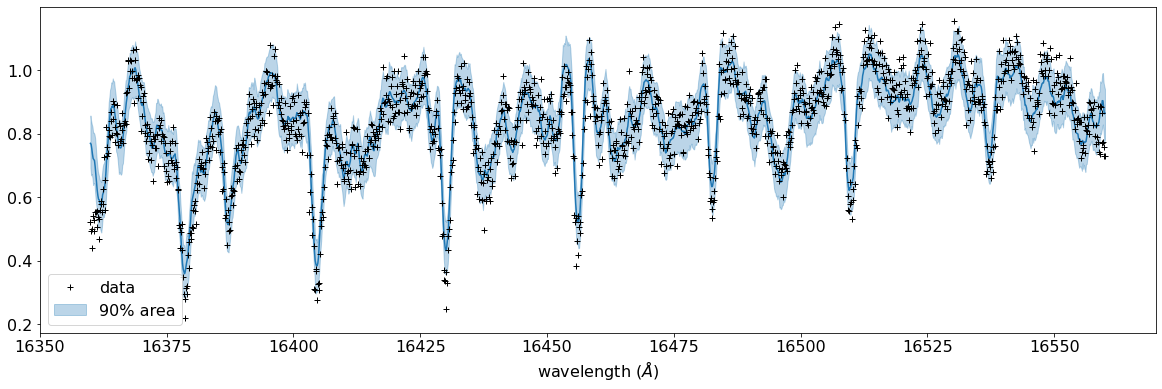

In [116]:
posterior_sample = mcmc.get_samples()
pred = Predictive(model_c,posterior_sample,return_sites=["y1"])
predictions = pred(rng_key_,nu1=nusd,y1=None)
median_mu1 = jnp.median(predictions["y1"],axis=0)
hpdi_mu1 = hpdi(predictions["y1"], 0.9)                                      
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,6.0))
ax.plot(wavd[::-1],median_mu1,color="C0")
ax.plot(wavd[::-1],nflux,"+",color="black",label="data")
ax.fill_between(wavd[::-1], hpdi_mu1[0], hpdi_mu1[1], alpha=0.3, interpolate=True,color="C0",label="90% area")
plt.xlabel("wavelength ($\AA$)",fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)

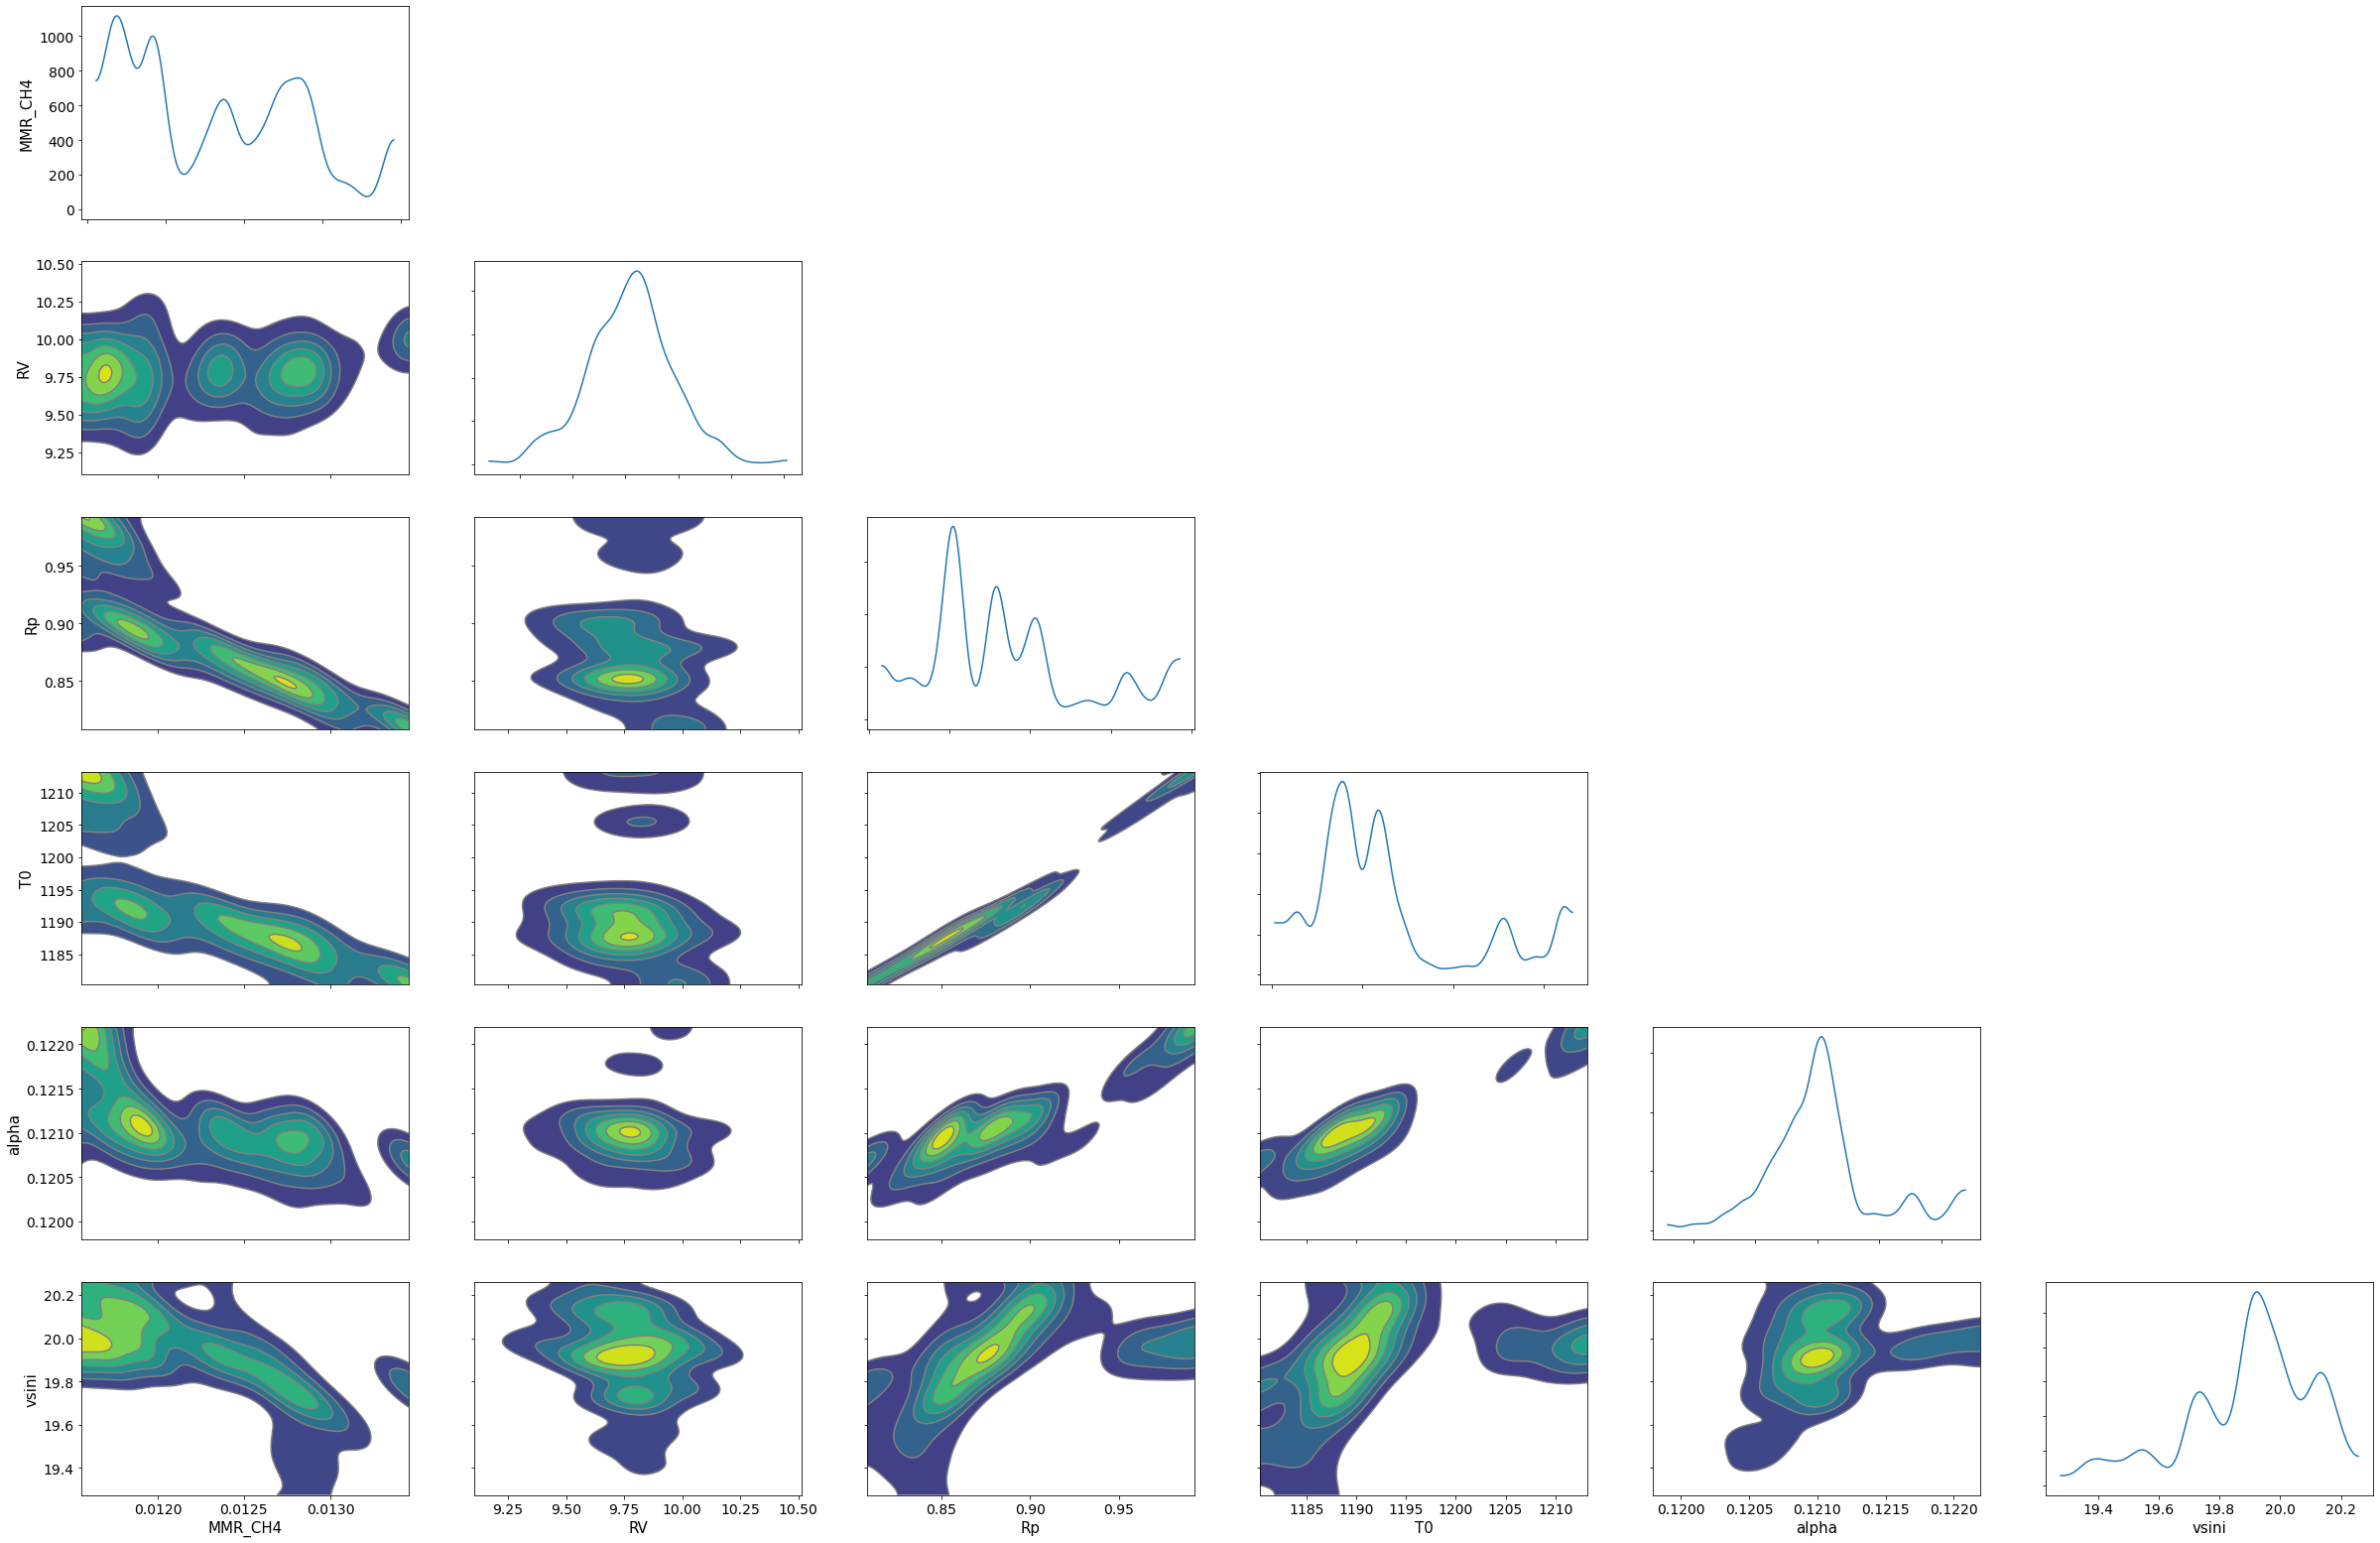

In [117]:
import arviz
pararr=["Rp","T0","alpha","MMR_CH4","vsini","RV"]
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,marginals=True)
plt.show()